In [132]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# 1. Tree-Based Methods

In [134]:
test_data=pd.read_csv('../hw6data/aps_failure_test_set.csv')
training_data=pd.read_csv('../hw6data/aps_failure_training_set.csv')

In [135]:
X_test=test_data.iloc[:,1:]
y_test=test_data.iloc[:,0]
X_test[X_test == 'na'] = np.nan
y_test.replace({'neg': 0, 'pos': 1}, inplace=True)

In [136]:
X_train=training_data.iloc[:,1:]
y_train=training_data.iloc[:,0]
y_train.replace({'neg': 0, 'pos': 1}, inplace=True)
X_train[X_train == 'na'] = np.nan

(b) Data Preparation
This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.


i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

Notes about missing value:

1. Naïve Bayes handles missing values by ignoring the sample during probability estimate calculations
2. The simplest strategy for handling missing data is to remove samples that contain a missing value (feature)

**Data Imputation:**<br>

1. Predict it based on other data points that do not have missing values. Examples: KNN regression and classification and Linear Regression
2. An iterative method based on Expectation Maximization 
3. A constant value that has meaning within the domain, such as 0, distinct from all other values
4. A value from another randomly selected record
5. A mean, median or mode value for the column
6. A value estimated by another predictive model



In [137]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_test)
X_test=pd.DataFrame(imp_median.transform(X_test),columns=X_test.columns)
X_train=pd.DataFrame(imp_median.transform(X_train),columns=X_train.columns)

In [138]:
X_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.0,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.0,156.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


ii. For each of the 170 features, calculate the coefficient of variation CV = s/m, where s is sample standard deviation and m is sample mean.

In [139]:
X_full=pd.concat([X_test, X_train])
y_full=pd.concat([y_test, y_train])

In [140]:
mean_values = X_full.mean()
std_values = X_full.std()
cv_values = std_values / mean_values
cv_df = pd.DataFrame({'Feature': X_full.columns, 'CV': cv_values})
print(cv_df)

       Feature          CV
aa_000  aa_000    4.328608
ab_000  ab_000    9.740521
ac_000  ac_000    2.309299
ad_000  ad_000  274.789176
ae_000  ae_000   23.271357
...        ...         ...
ee_007  ee_007    4.935253
ee_008  ee_008    3.373844
ee_009  ee_009    5.821008
ef_000  ef_000   50.223681
eg_000  eg_000   47.845392

[170 rows x 2 columns]


iii. Plot a correlation matrix for your features using pandas or any other tool.


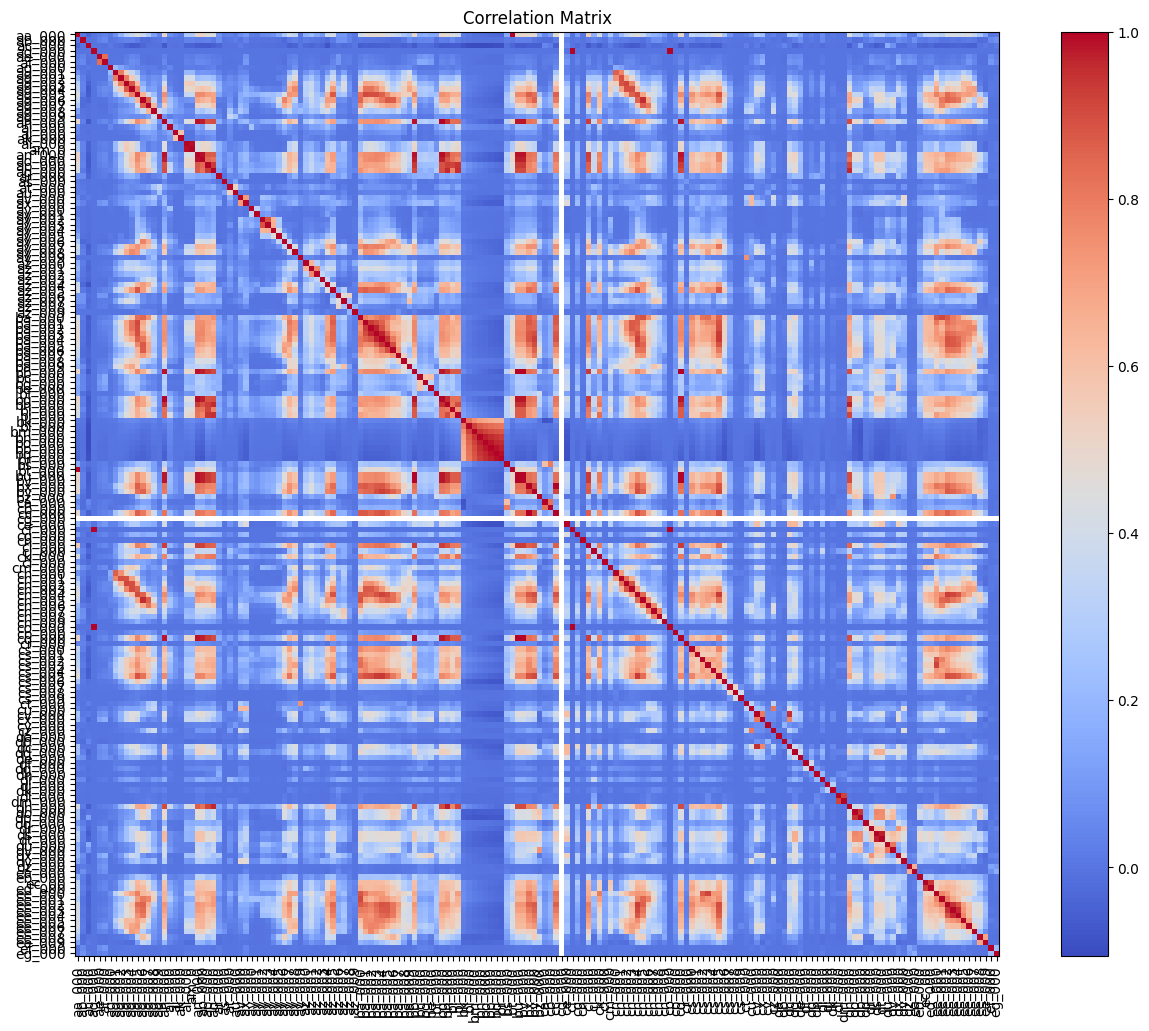

In [141]:
corr_matrix = X_full.corr()

plt.figure(figsize=(16, 12))
plt.title("Correlation Matrix")
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

iv. Pick sqrt(170) features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.


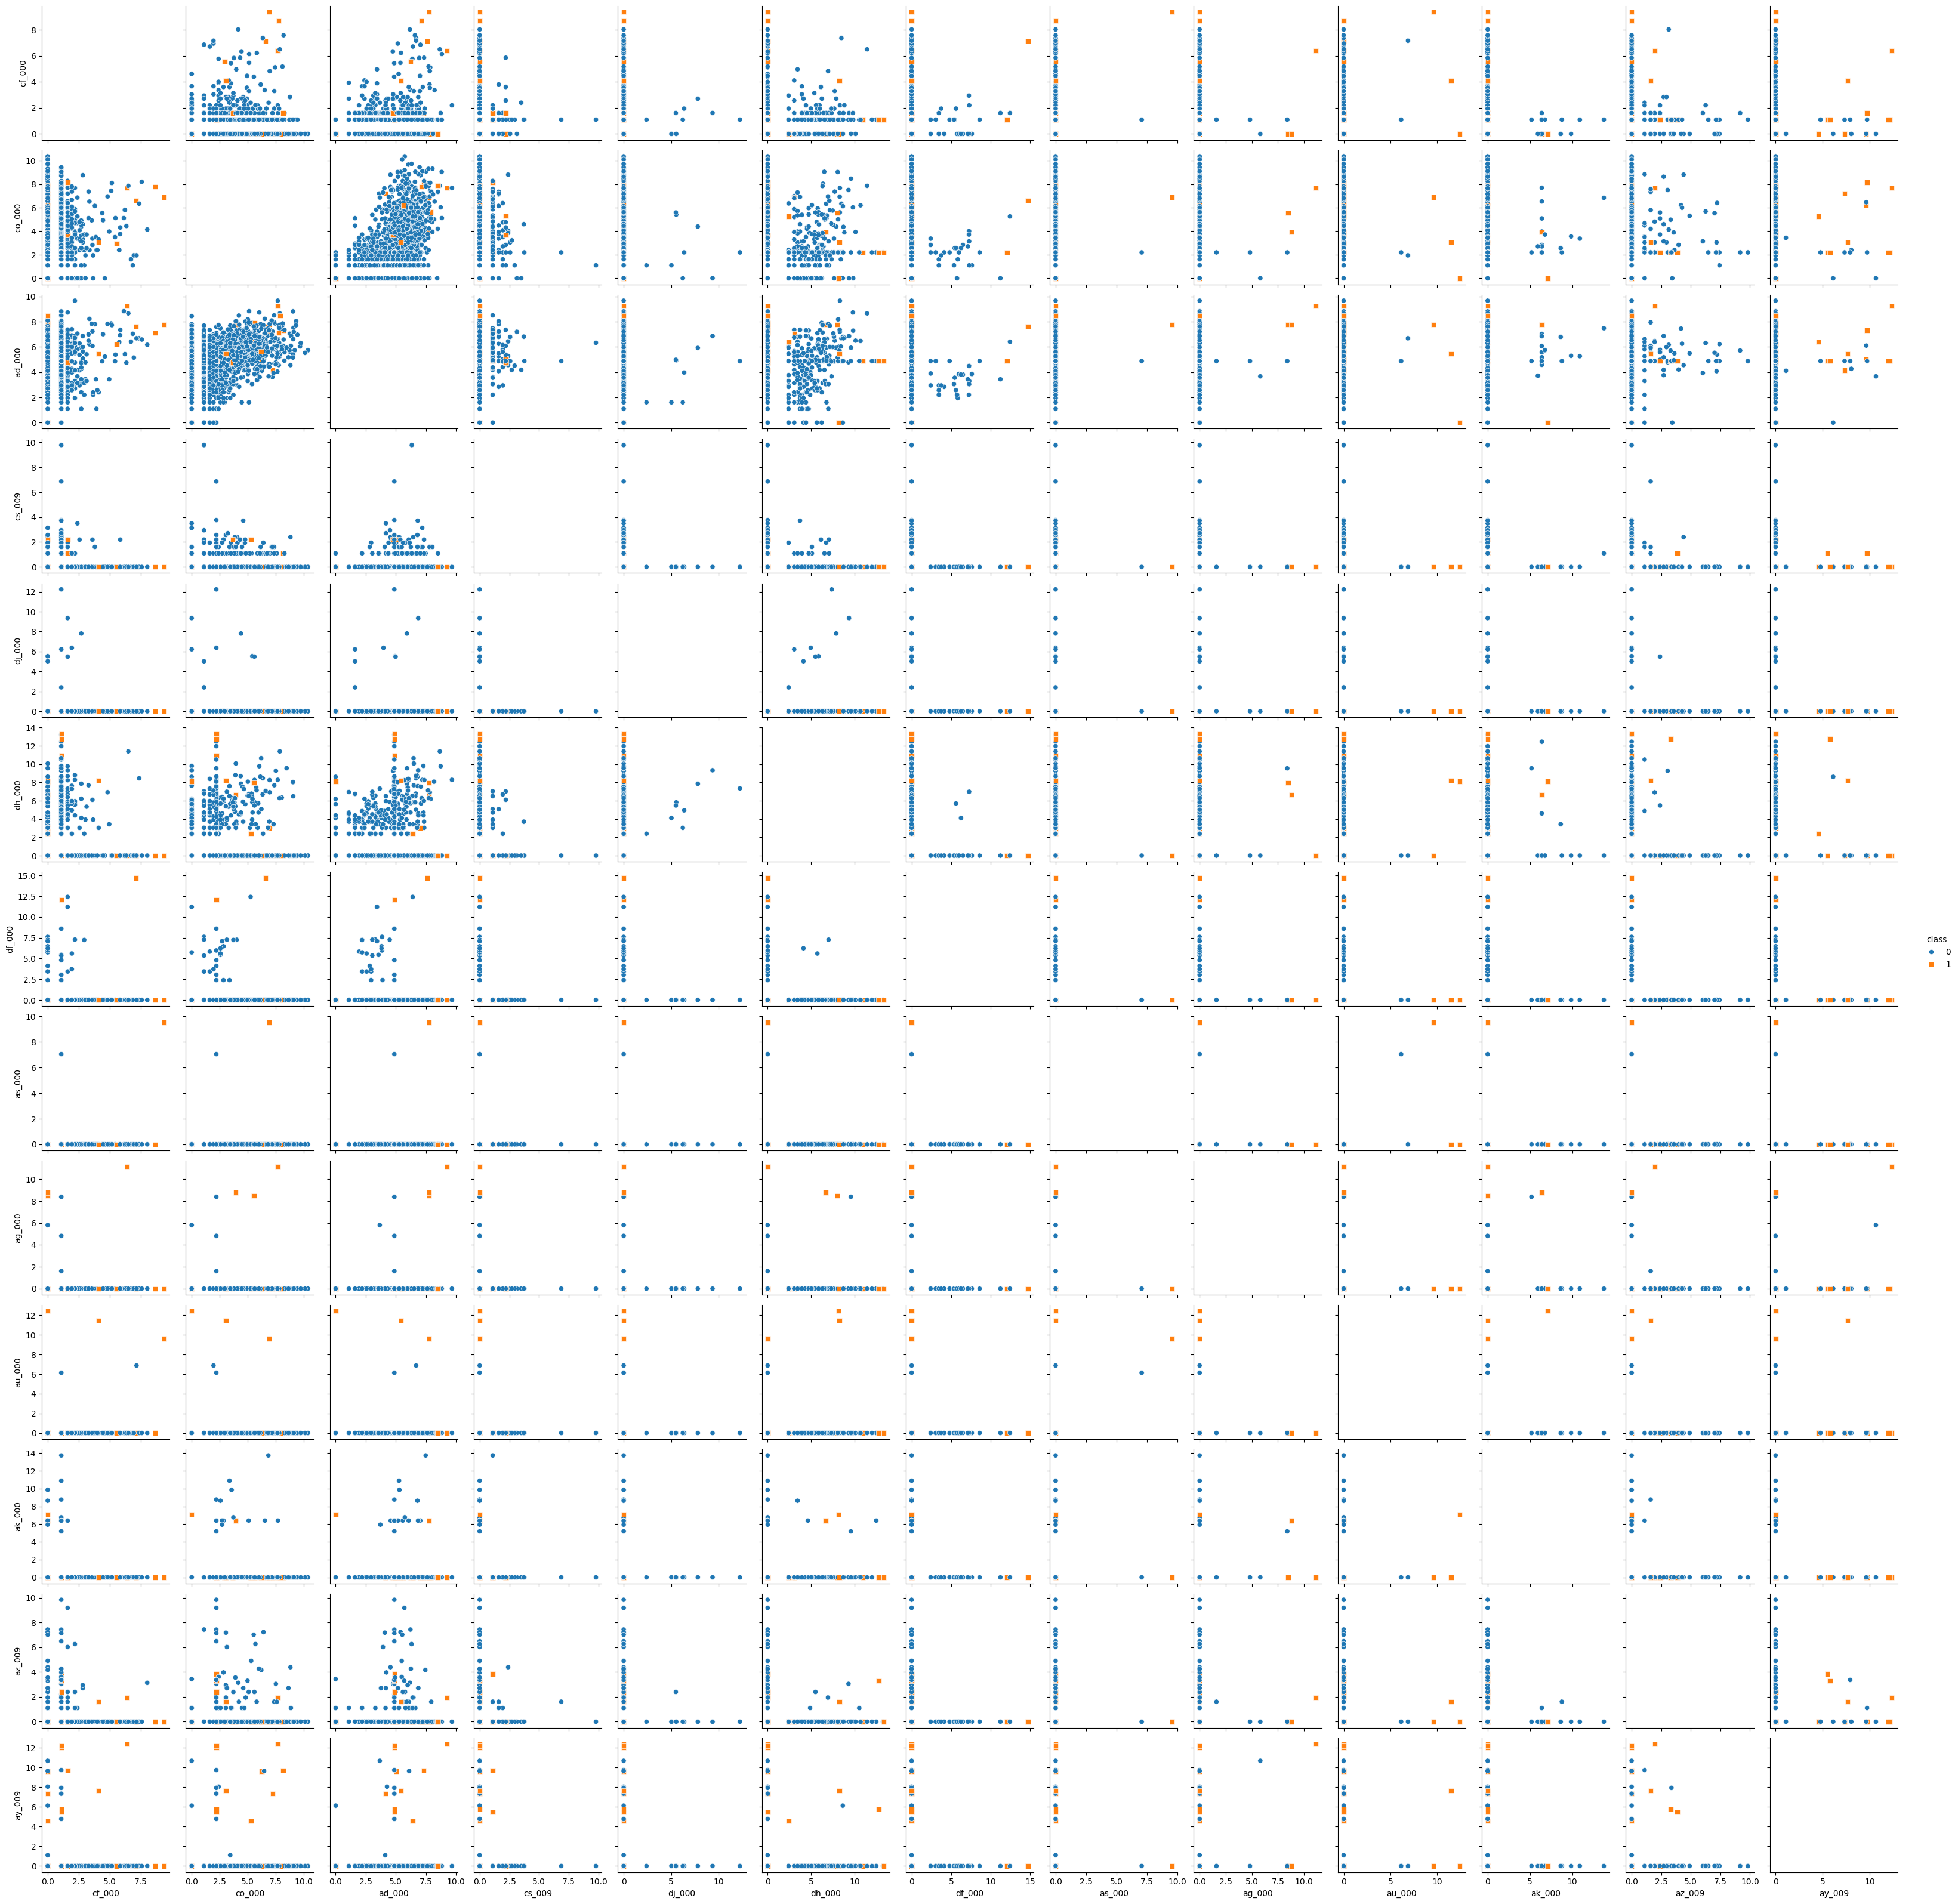

In [142]:
top_features = cv_values.nlargest(13).index
top_X=X_full[top_features]
top_X_log = top_X.apply(lambda x: np.log(x + 1)) 
top_data = pd.concat([top_X_log, y_full], axis=1)

sample_size = 2000
top_data_sampled = top_data.sample(n=sample_size, random_state=42)

sns.pairplot(top_data_sampled, hue="class", markers=["o", "s"], diag_kind="none")
plt.show()

v. Determine the number of positive and negative data. Is this data set imbalanced?

In [143]:
positive_count = (y_full == 1).sum()
negative_count = (y_full == 0).sum()

total_count = len(y_full)
positive_proportion = positive_count / total_count
negative_proportion = negative_count / total_count

print(f'Positive: {round(positive_proportion,2)}%')
print(f'Negative: {round(negative_proportion,2)}%')

Positive: 0.02%
Negative: 0.98%


The data is imbalanced.

(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [144]:
rf_classifier = RandomForestClassifier(random_state=0, oob_score=True)
rf_classifier.fit(X_train, y_train)

y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

In [145]:
def rf_summary(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, model):

    confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

    misclassification_train = np.mean(y_train != y_train_pred)
    misclassification_test = np.mean(y_test != y_test_pred)

    oob_error = 1 - model.oob_score_

    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

    roc_auc_train = roc_auc_score(y_train, y_train_prob)
    roc_auc_test = roc_auc_score(y_test, y_test_prob)

    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)

    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Training ROC Curve (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print("Confusion Matrix (Training Set):\n", confusion_matrix_train)
    print("Confusion Matrix (Test Set):\n", confusion_matrix_test)
    print("ROC AUC (Training Set):", roc_auc_train)
    print("ROC AUC (Test Set):", roc_auc_test)
    print("Misclassification Rate (Training Set):", misclassification_train)
    print("Misclassification Rate (Test Set):", misclassification_test)
    print("OOB Error Estimate:", oob_error)
    print("Precision (Training Set):", precision_train)
    print("Precision (Test Set):", precision_test)
    print("Recall (Training Set):", recall_train)
    print("Recall (Test Set):", recall_test)

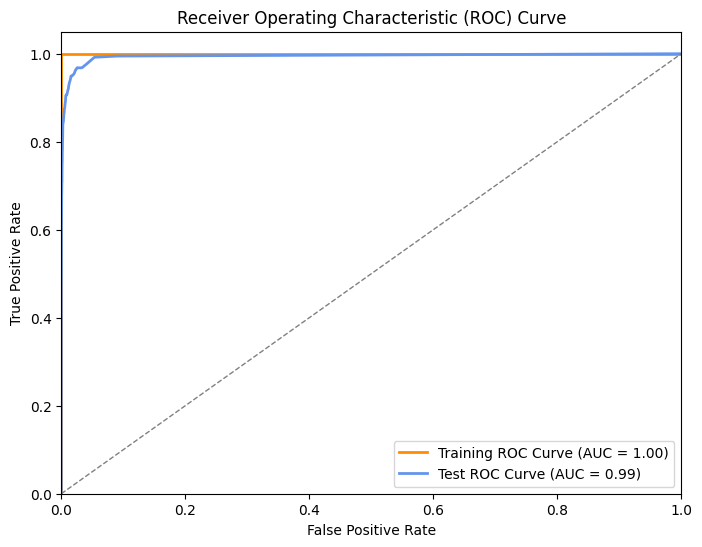

Confusion Matrix (Training Set):
 [[59000     0]
 [    0  1000]]
Confusion Matrix (Test Set):
 [[15607    18]
 [  109   266]]
ROC AUC (Training Set): 1.0
ROC AUC (Test Set): 0.9942282240000001
Misclassification Rate (Training Set): 0.0
Misclassification Rate (Test Set): 0.0079375
OOB Error Estimate: 0.0060833333333333295
Precision (Training Set): 1.0
Precision (Test Set): 0.9366197183098591
Recall (Training Set): 1.0
Recall (Test Set): 0.7093333333333334


In [146]:
rf_summary(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, rf_classifier)

(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

**Bagging for Imbalanced Classification**
1. Standard Bagging
2. Bagging With Random Undersampling

**Random Forest for Imbalanced Classification**
1. Standard Random Forest
2. Random Forest With Class Weighting
3. Random Forest With Bootstrap Class Weighting (class_weight='balanced')
4. Random Forest With Random Undersampling (class_weight='balanced_subsample')
5. Easy Ensemble for Imbalanced Classification (BalancedRandomForestClassifier)
6. Easy Ensemble (EasyEnsembleClassifier)

cr: https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

In [147]:
rf_classifier_balanced = RandomForestClassifier(random_state=0, oob_score=True, class_weight='balanced')
rf_classifier_balanced.fit(X_train, y_train)

y_train_pred_balanced = rf_classifier_balanced.predict(X_train)
y_test_pred_balanced = rf_classifier_balanced.predict(X_test)

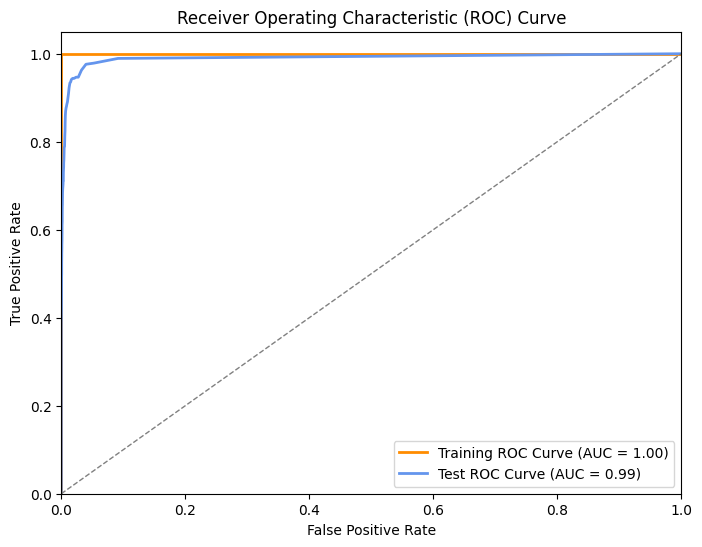

Confusion Matrix (Training Set):
 [[59000     0]
 [    0  1000]]
Confusion Matrix (Test Set):
 [[15610    15]
 [  165   210]]
ROC AUC (Training Set): 1.0
ROC AUC (Test Set): 0.9902579199999999
Misclassification Rate (Training Set): 0.0
Misclassification Rate (Test Set): 0.01125
OOB Error Estimate: 0.007783333333333364
Precision (Training Set): 1.0
Precision (Test Set): 0.9333333333333333
Recall (Training Set): 1.0
Recall (Test Set): 0.56


In [148]:
rf_summary(X_train, X_test, y_train, y_test, y_train_pred_balanced, y_test_pred_balanced, rf_classifier_balanced)

In [149]:
rf_classifier_balanced2 = RandomForestClassifier(random_state=0, oob_score=True, class_weight='balanced_subsample')
rf_classifier_balanced2.fit(X_train, y_train)

y_train_pred_balanced2 = rf_classifier_balanced.predict(X_train)
y_test_pred_balanced2 = rf_classifier_balanced.predict(X_test)

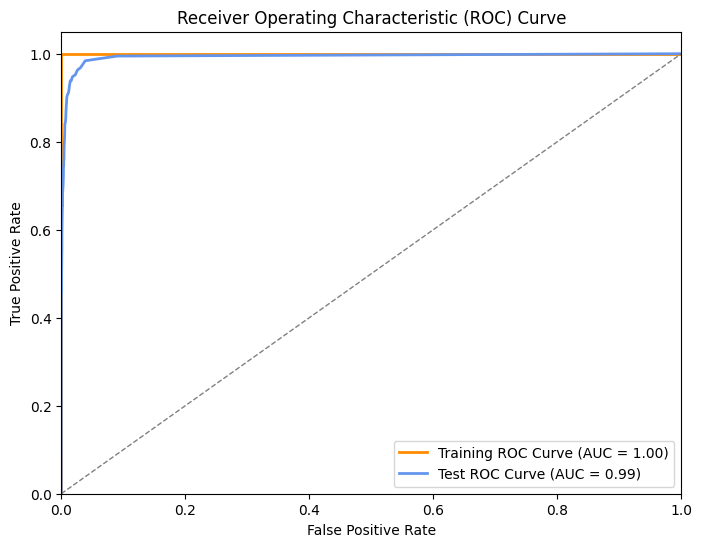

Confusion Matrix (Training Set):
 [[59000     0]
 [    0  1000]]
Confusion Matrix (Test Set):
 [[15610    15]
 [  165   210]]
ROC AUC (Training Set): 1.0
ROC AUC (Test Set): 0.9933330773333334
Misclassification Rate (Training Set): 0.0
Misclassification Rate (Test Set): 0.01125
OOB Error Estimate: 0.007950000000000013
Precision (Training Set): 1.0
Precision (Test Set): 0.9333333333333333
Recall (Training Set): 1.0
Recall (Test Set): 0.56


In [150]:
rf_summary(X_train, X_test, y_train, y_test, y_train_pred_balanced2, y_test_pred_balanced2, rf_classifier_balanced2)

In this specific case, the unimbalanced data resulted in better model performance.

**(e) XGBoost and Model Trees**

In [151]:
# Reference: https://datascience.stackexchange.com/questions/29824/using-l1-penalty-in-xgboost

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
alphas = [0.001, 0.01, 0.1, 1, 10]

best_alpha = None
best_score = 0
for alpha in alphas:
    xgb_model.set_params(alpha=alpha)
    scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print(f'Best alpha is {best_alpha}')
xgb_model.set_params(alpha=best_alpha)
xgb_model.fit(X_train, y_train)

Best alpha is 0.01


XGBClassifier(alpha=0.01, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [152]:
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

In [153]:
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

y_train_prob = xgb_model.predict_proba(X_train)[:, 1]
y_test_prob = xgb_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = roc_auc_score(y_train, y_train_prob)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = roc_auc_score(y_test, y_test_prob)

print("Optimal α:", best_alpha)
print("Confusion Matrix (Training Set):\n", confusion_matrix_train)
print("Confusion Matrix (Test Set):\n", confusion_matrix_test)
print("ROC AUC (Training Set):", roc_auc_train)
print("ROC AUC (Test Set):", roc_auc_test)

Optimal α: 0.01
Confusion Matrix (Training Set):
 [[59000     0]
 [    0  1000]]
Confusion Matrix (Test Set):
 [[15607    18]
 [  109   266]]
ROC AUC (Training Set): 0.9999999322033899
ROC AUC (Test Set): 0.9947636053333334


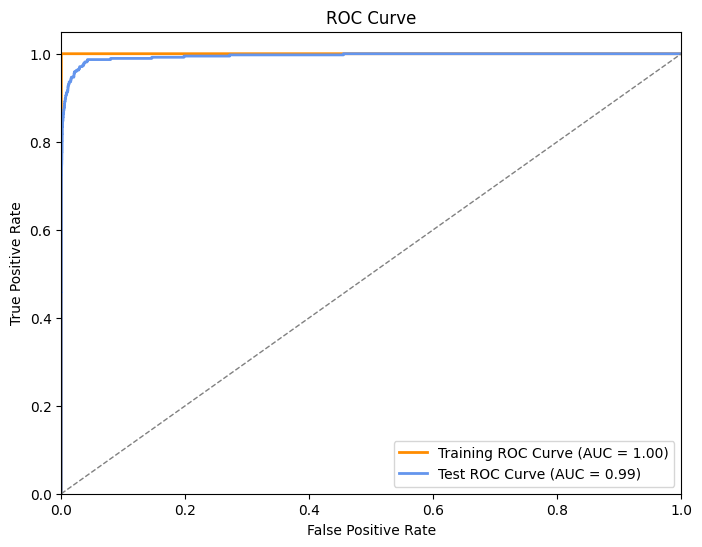

In [154]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Training ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**(f) SMOTE**

Reference: https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7#:~:text=We%20first%20split%20the%20data,cross%2Dvalidation%20and%20test%20scores

In [155]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('classifier', xgb_model)
])

In [158]:
stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:160: UserWarning: [23:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "C" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:160: UserWarning: [23:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "C" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:160: UserWarning: [23:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "C" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\云忆\A

Confusion Matrix (Training Set):
 [[59000     0]
 [    1   999]]
Confusion Matrix (Test Set):
 [[15577    48]
 [   68   307]]
ROC AUC (Training Set): 0.9999805677966103
ROC AUC (Test Set): 0.9946874880000001
Precision (Training Set): 1.0
Precision (Test Set): 0.8647887323943662
Recall (Training Set): 0.999
Recall (Test Set): 0.8186666666666667


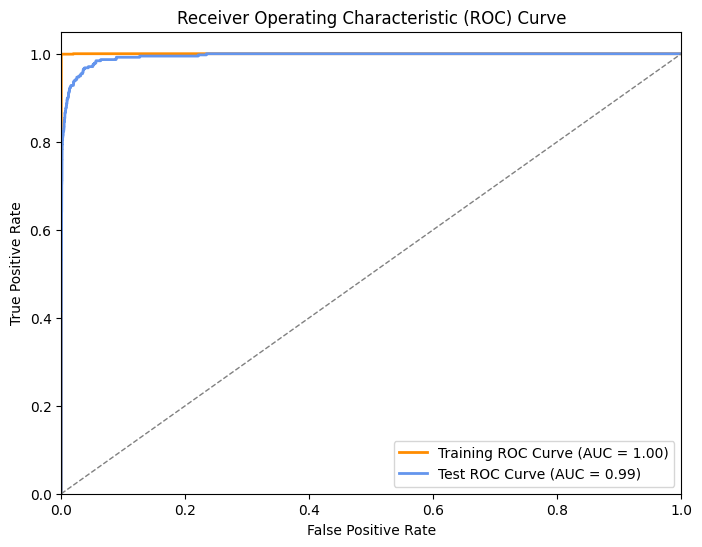

In [160]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = roc_auc_score(y_train, y_train_prob)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = roc_auc_score(y_test, y_test_prob)

precision_train = precision_score(y_train, y_train_pred)
precision_test = precision_score(y_test, y_test_pred)

recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print("Confusion Matrix (Training Set):\n", confusion_matrix_train)
print("Confusion Matrix (Test Set):\n", confusion_matrix_test)

print("ROC AUC (Training Set):", roc_auc_train)
print("ROC AUC (Test Set):", roc_auc_test)

print("Precision (Training Set):", precision_train)
print("Precision (Test Set):", precision_test)
print("Recall (Training Set):", recall_train)
print("Recall (Test Set):", recall_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Training ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Please find ISLR Questions in another PDF file. Thank you.